## Maximum Possible Accuracy using Zoom

In [29]:
import json
import os
import pickle
import random
from functools import partial
from glob import glob

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as fv
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import matplotlib.patches as patches

from collections import defaultdict

sns.set()

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)


### Helpers

In [30]:
dataset_names = [
    "imagenet_1k",
    "imagenet_1k_real",
    "imagenet_IN_plus_real",
    "imagenet_r",
    "imagenet_a",
    "imagenet_sketch",
    "objectnet",
]

model_names = ["resnet18", "resnet50", "vit32", "vgg16", "alexnet", "clip_vit_l_14"]

model_name_lookup = {
    "resnet18": "resnet18",
    "resnet50": "resnet50",
    "vit32": "vit_b_32",
    "vgg16": "vgg16",
    "alexnet": "alexnet",
    "clip_vit_l_14": "clip_vit_l_14"
}

pretty_model_names = {
    "resnet18": "ResNet-18",
    "resnet50": "ResNet-50",
    "vit32": "ViT-B/32",
    "vgg16": "VGG-16",
    "alexnet": "AlexNet",
    "clip_vit_l_14": "CLIP ViT-L/14"
}

pretty_dataset_names = {
    "imagenet_1k": "ImageNet",
    "imagenet_1k_real": "ImageNet ReaL",
    "imagenet_IN_plus_real": "ImageNet + ReaL",
    "imagenet_r": "ImageNet-R",
    "imagenet_a": "ImageNet-A",
    "imagenet_sketch": "ImageNet-Sketch",
    "objectnet": "ObjectNet",
}


### Load results

In [31]:
with open('../data/correctness.pkl', 'rb') as f:
    correctness_dfs = pickle.load(f)

## Classification Results

1. Standard 1-crop accuracy
2. Maximum possible accuracy

In [32]:
standard_accuracy = defaultdict(dict)
max_possible_accuracy = defaultdict(dict)

for dataset in dataset_names:
    for model in model_names:
        standard_accuracy[dataset][model] = 100* correctness_dfs[dataset][model].loc['LOC:1_1_Size:256'].mean()
        max_possible_accuracy[dataset][model]  = 100*np.mean(correctness_dfs[dataset][model].max(0))

In [33]:
s_acc_df = pd.DataFrame(standard_accuracy)
s_acc_df.index = [pretty_model_names[i] for i in s_acc_df.index]
s_acc_df.columns = [pretty_dataset_names[i] for i in s_acc_df.columns]
s_acc_df.round(2)

,ImageNet,ImageNet ReaL,ImageNet + ReaL,ImageNet-R,ImageNet-A,ImageNet-Sketch,ObjectNet
ResNet-18,69.45,76.94,76.47,32.14,1.37,19.41,27.59
ResNet-50,75.75,82.63,82.97,35.39,0.21,22.91,36.18
ViT-B/32,75.75,81.89,82.59,41.29,9.64,26.83,30.89
VGG-16,71.37,78.90,78.52,26.98,2.69,16.78,28.32
AlexNet,56.16,62.67,61.76,21.10,1.75,10.05,14.23
CLIP ViT-L/14,75.04,80.69,81.95,86.83,71.28,58.23,66.32


In [34]:
m_acc_df = pd.DataFrame(max_possible_accuracy)
m_acc_df.index = [pretty_model_names[i] for i in m_acc_df.index]
m_acc_df.columns = [pretty_dataset_names[i] for i in m_acc_df.columns]
m_acc_df.round(2)

,ImageNet,ImageNet ReaL,ImageNet + ReaL,ImageNet-R,ImageNet-A,ImageNet-Sketch,ObjectNet
ResNet-18,95.15,97.76,97.55,66.89,58.87,43.68,71.44
ResNet-50,96.78,98.62,98.57,68.84,66.68,47.64,76.83
ViT-B/32,97.19,98.75,98.91,75.58,78.03,55.99,79.28
VGG-16,95.30,97.90,97.66,60.88,58.27,39.90,71.85
AlexNet,90.03,93.85,93.48,55.52,42.23,29.53,59.65
CLIP ViT-L/14,96.78,98.70,98.80,99.20,98.49,89.00,93.13


## Accuracy breakdown by anchor point

In [35]:
def plot_max_accuracy_3x3_grid(df, dataset_name):

    N_models = len(df.keys())
    fig, axes = plt.subplots(1, N_models, figsize=(5*N_models, 5))


    for T, model in enumerate(df.keys()):
        axes[T].set_xticks([])
        axes[T].set_yticks([])
        axes[T].set_title(pretty_model_names[model])

        for i in range(3):
            for j in range(3):
                
                list_of_index = list(df[model].index)
                current_patch = [x for x in list_of_index if f"LOC:{i}_{j}" in x]
                accuracy = (100 * np.mean(df[model].loc[current_patch].max(axis=0))).round(2)
                # convert accuracy to gradient color
                shade_color = matplotlib.colormaps["Greens"](accuracy/100)
                
                axes[T].add_patch( patches.Rectangle((i/3, j/3), 1/3, 1/3, edgecolor='black', lw=3, alpha=0.5, zorder=1, clip_on=False, facecolor=shade_color))
                
                
                axes[T].text(i/3 + 1/6, j/3 + 1/6, accuracy, fontsize=16, ha='center', va='center')
            
            
    fig.suptitle(dataset_name, fontsize=20)
    plt.show()


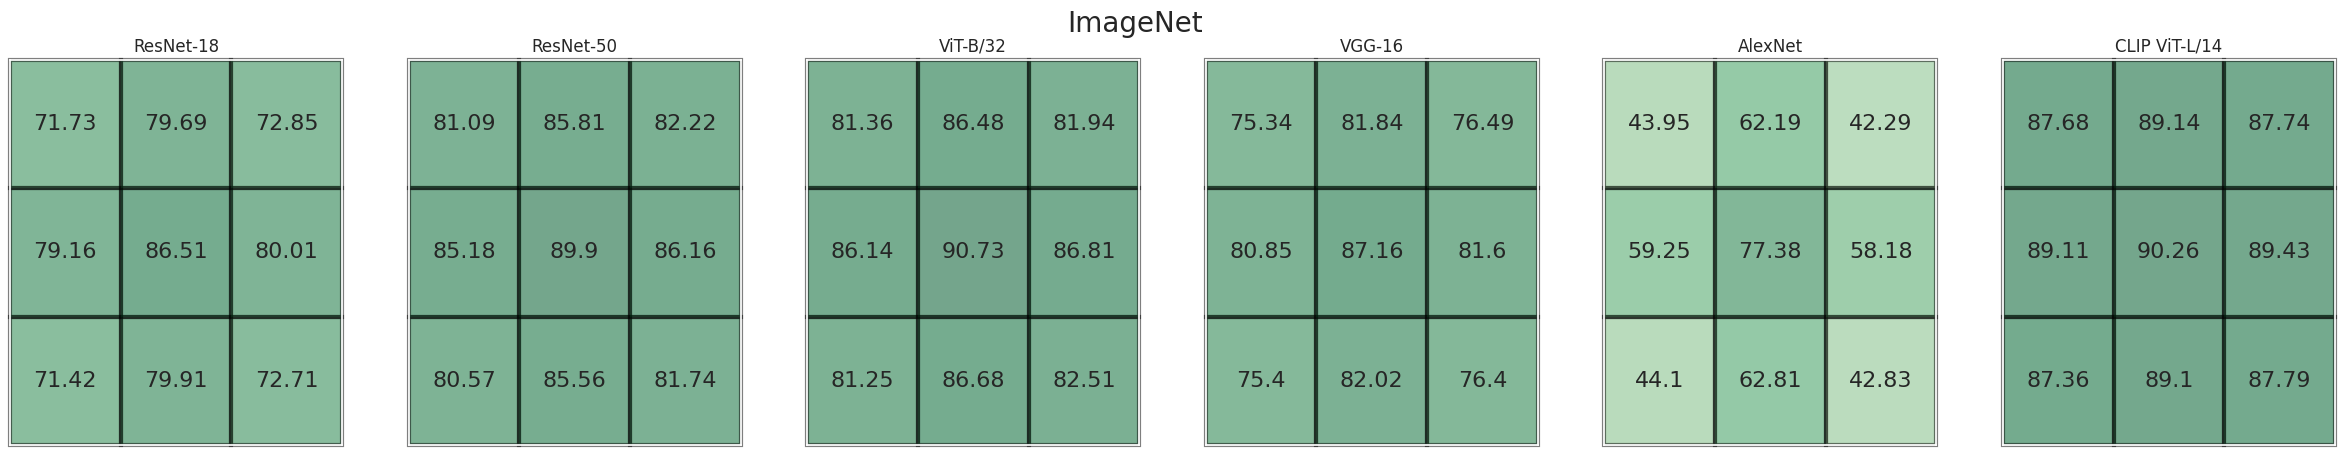

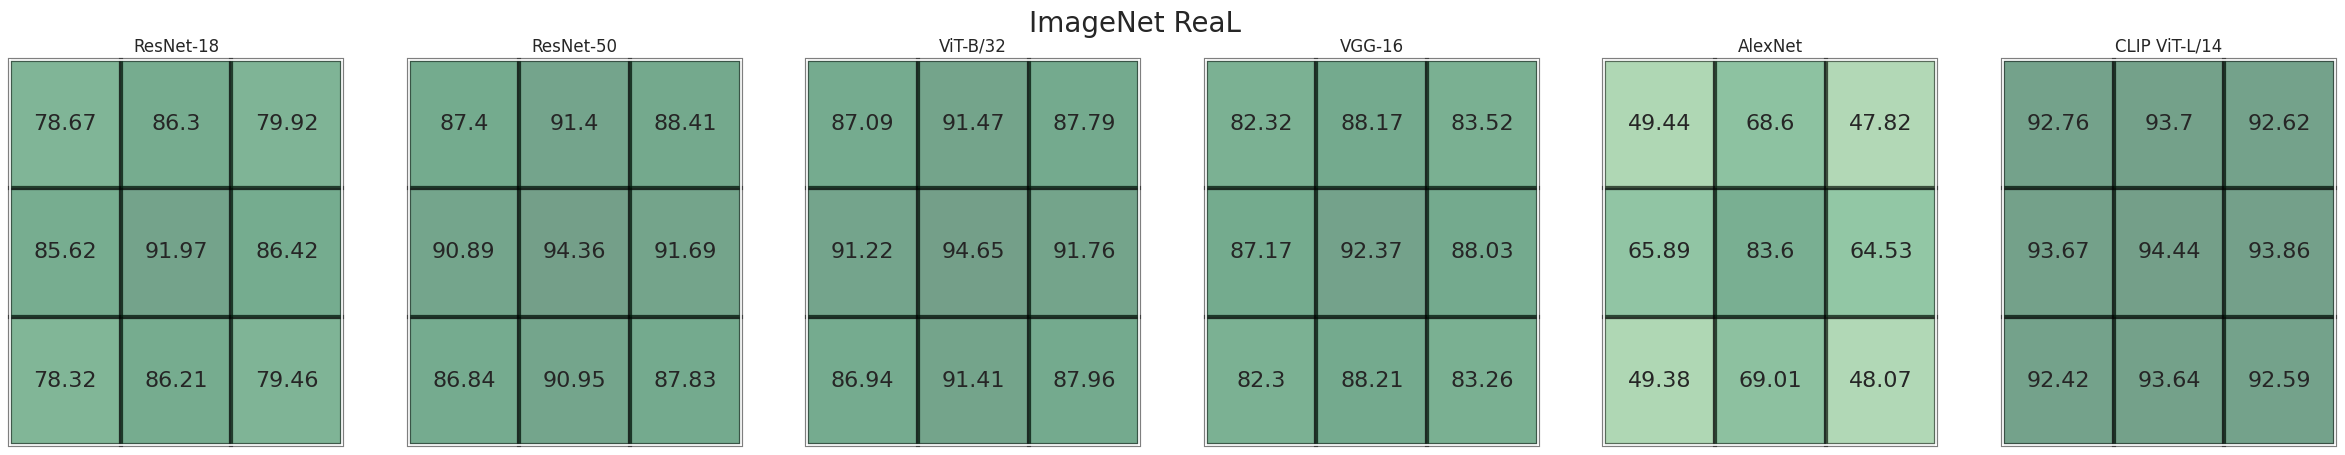

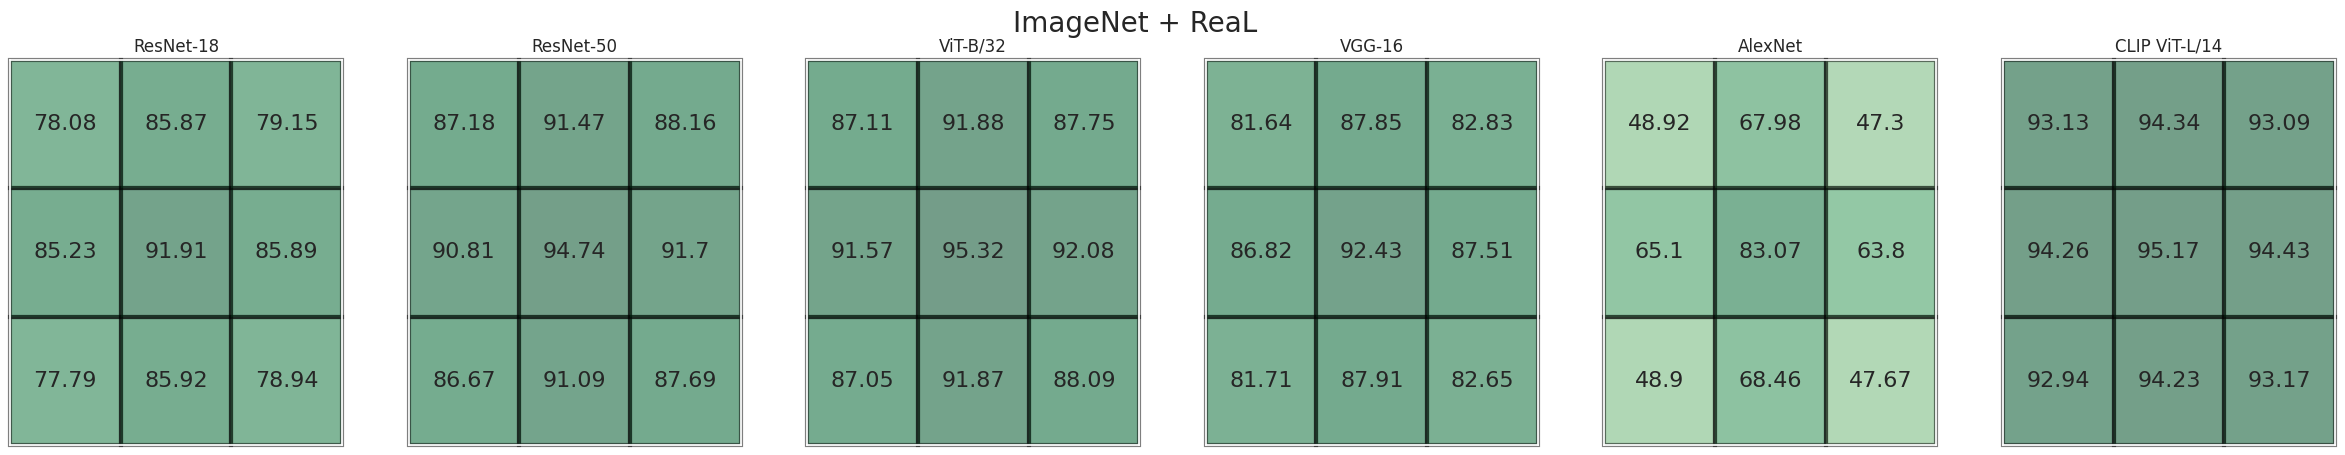

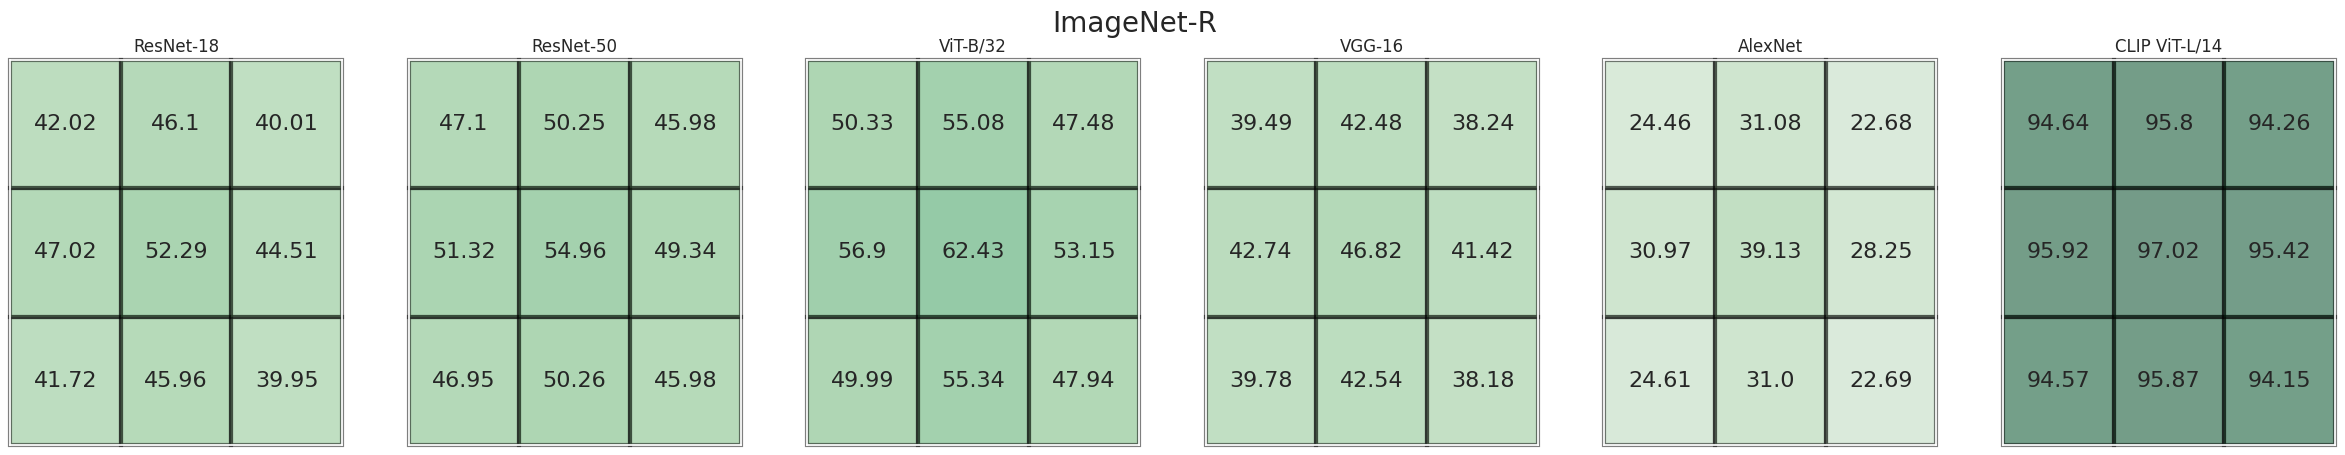

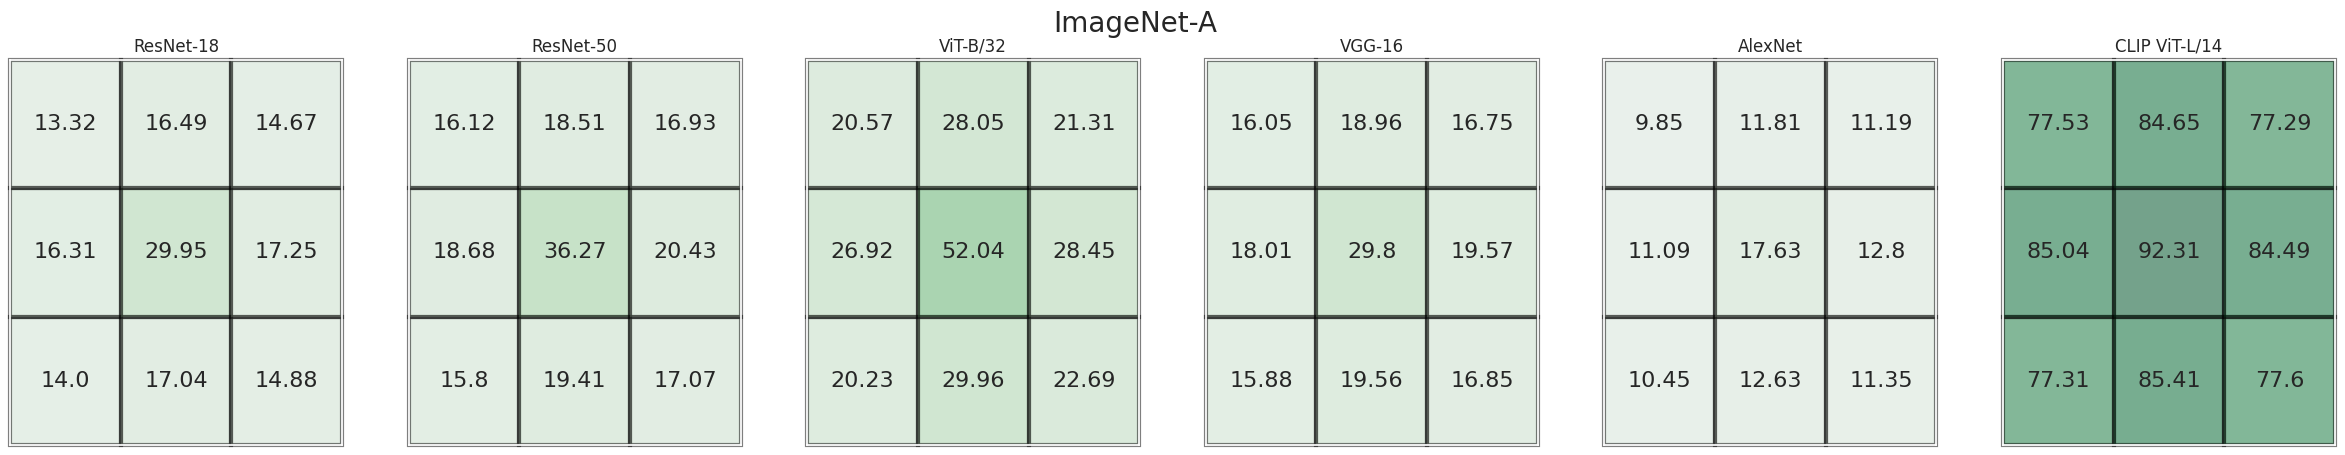

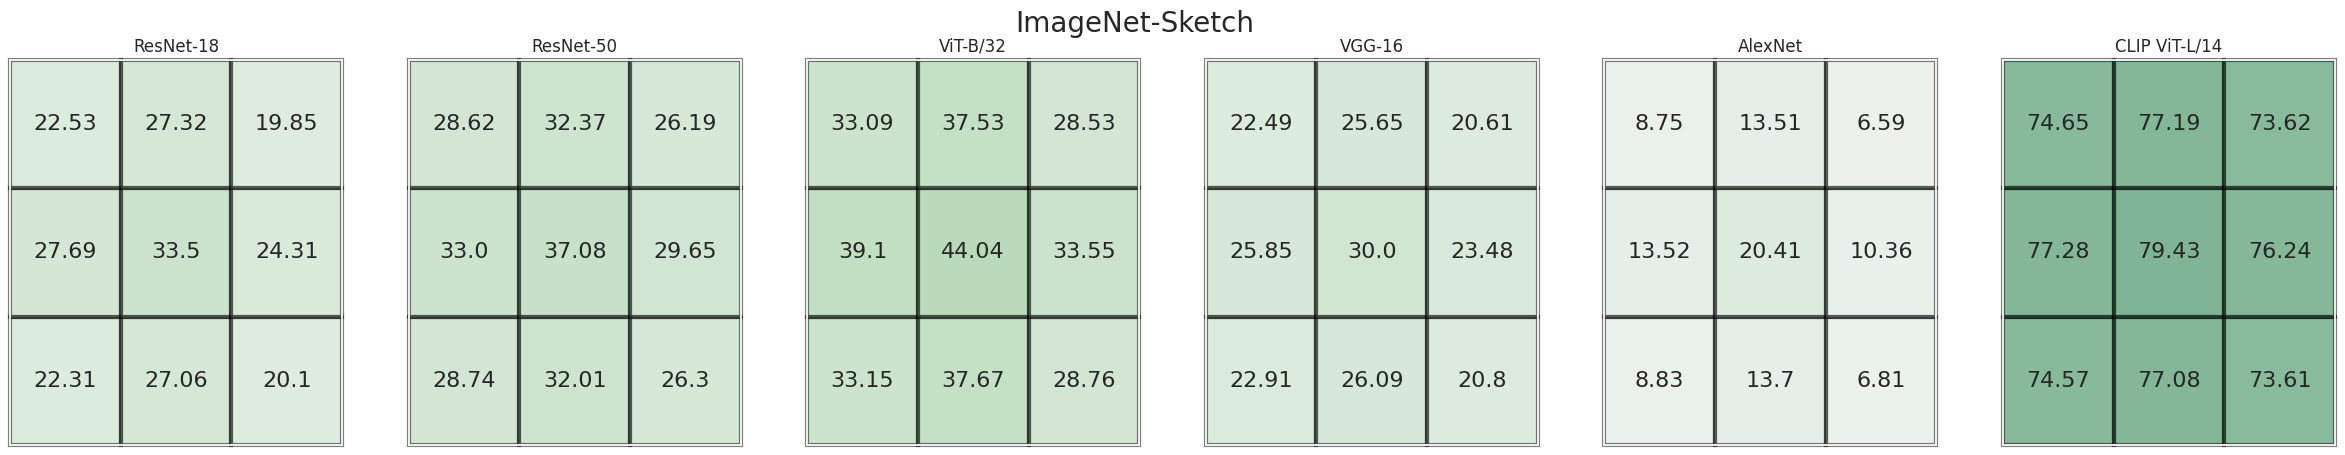

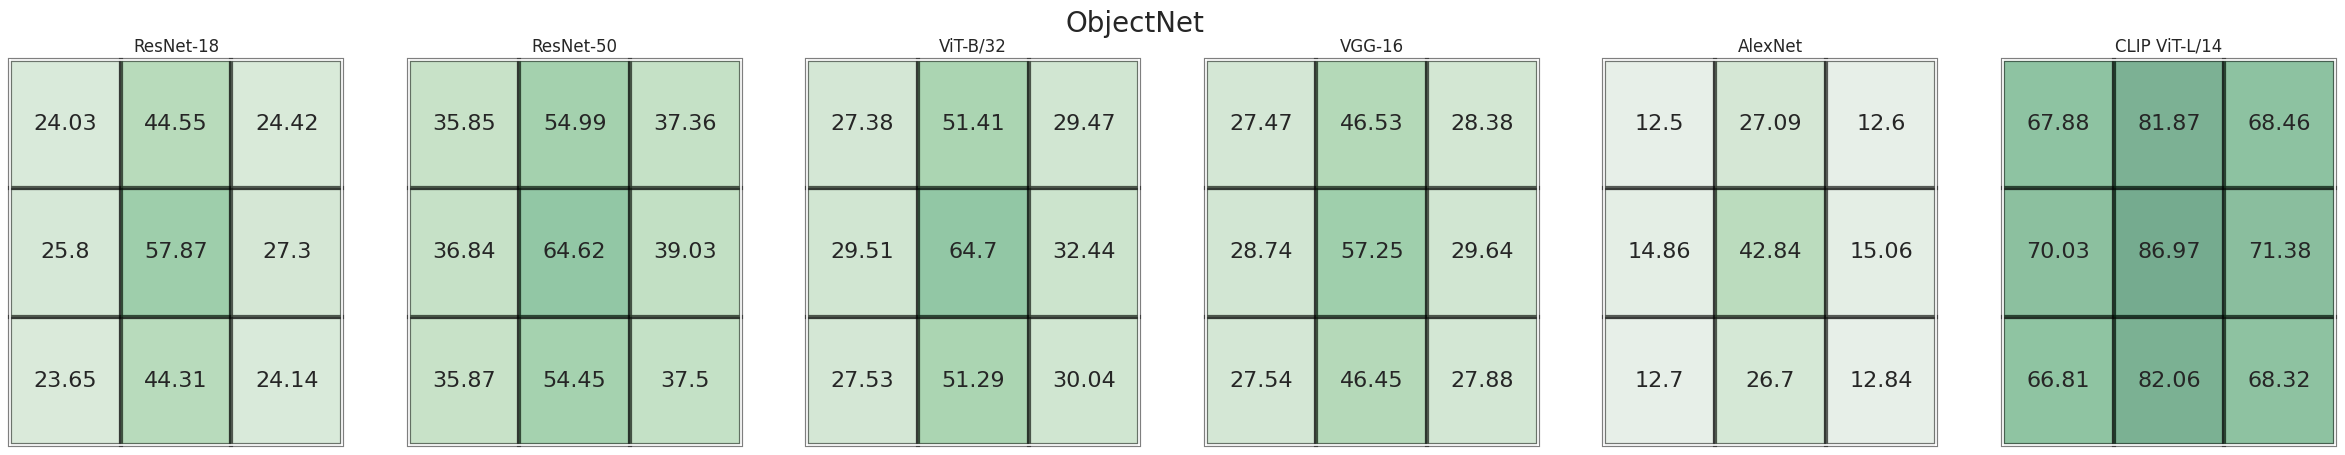

In [36]:
for dataset in dataset_names:
    plot_max_accuracy_3x3_grid(correctness_dfs[dataset], pretty_dataset_names[dataset])

## Waterfall plots

In [37]:
def generate_transform_size_list():
    tsize_list = [
        10,
        16,
        32,
        48,
        64,
        96,
        128,
        192,
        224,
        240,
        256,
        288,
        320,
        384,
        448,
        512,
        576,
        640,
        664,
        672,
        680,
        690,
        700,
        720,
        768,
        832,
        896,
    ]
    tsize_list = tsize_list + [int(x) for x in np.linspace(10, 1024, 10)][1:]

    return list(sorted(tsize_list))


all_tsizes = generate_transform_size_list()

In [38]:
def plot_waterfall_all(SELECTED_DATASET):
    model_correctness_pair = correctness_dfs[SELECTED_DATASET]
    # exclude CLIP
    model_correctness_pair = {
        k: v for k, v in model_correctness_pair.items() if k != "clip_vit_l_14"
    }
    accuraccies = {}

    t_above_100 = [t for t in all_tsizes if t > 100]
    sample_index = list(model_correctness_pair["resnet18"].index)

    for tsize in t_above_100:
        subset = [x for x in sample_index if f":{tsize}" in x]
        acc_lst = []
        for k in model_correctness_pair.keys():
            acc_lst.append(np.mean(model_correctness_pair[k].loc[subset].max()))

        accuraccies[tsize] = acc_lst

    min_trend_line = [np.min(x) for x in accuraccies.values()]
    max_trend_line = [np.max(x) for x in accuraccies.values()]
    mean_trend_line = [np.mean(x) for x in accuraccies.values()]

    sns.set(font_scale=1.5)
    sns.set_palette("Set1")
    colors = sns.color_palette("Set2", 6)

    with sns.axes_style(
        "whitegrid",
        {
            "axes.grid": True,
            "grid.color": ".8",
            "grid.linestyle": "-",
            "grid.linewidth": 1.0,
        },
    ):
        sns.set(font_scale=1)
        sns.set_palette("Set2")

        sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})

        fig, ax = plt.subplots(1, figsize=(5, 5))
        accuracies_df = pd.DataFrame(accuraccies)
        accuracies_df.index = model_correctness_pair.keys()
        accuracies_df = accuracies_df.T

        for i, model in enumerate(accuracies_df.columns):
            plt.plot(
                t_above_100,
                accuracies_df[model],
                linewidth=2,
                alpha=1,
                markerfacecolor="white",
                markeredgewidth=2,
                markeredgecolor="black",
                zorder=1,
                color=colors[i],
                label=model_name_lookup[model],
            )

        plt.plot(
            t_above_100, mean_trend_line, "--", color="black", linewidth=2, label="Mean"
        )
        plt.vlines(
            x=256,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
            linewidth=2,
            zorder=3,
            alpha=0.5,
        )

        plt.xlabel("Zoom scale", fontsize=16)
        plt.ylabel("Maximum 9-crop Accuracy", fontsize=16)
        plt.ylim(0, 1)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.tight_layout()
        plt.legend(loc="upper right", fontsize=12, ncol=1)


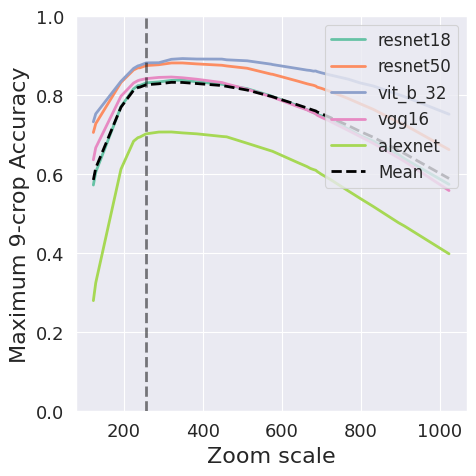

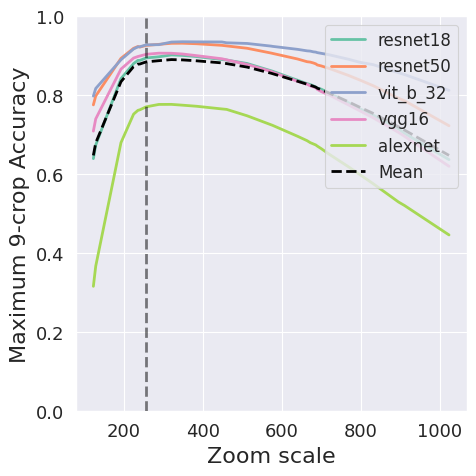

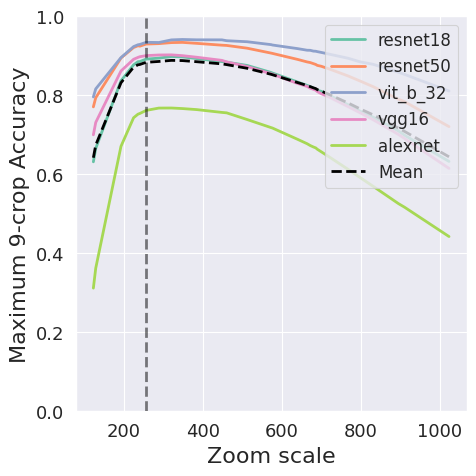

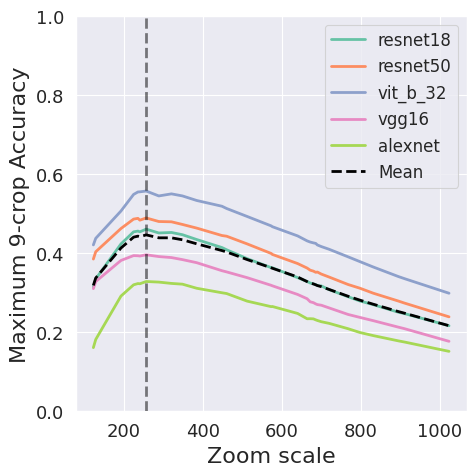

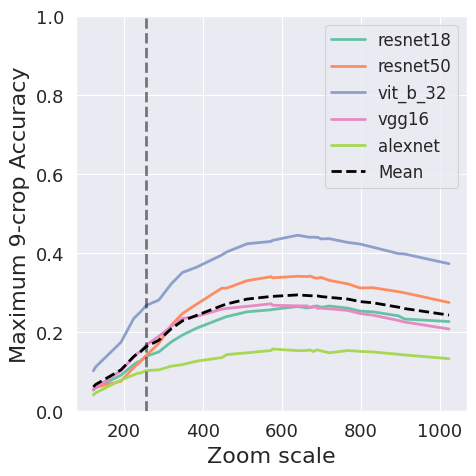

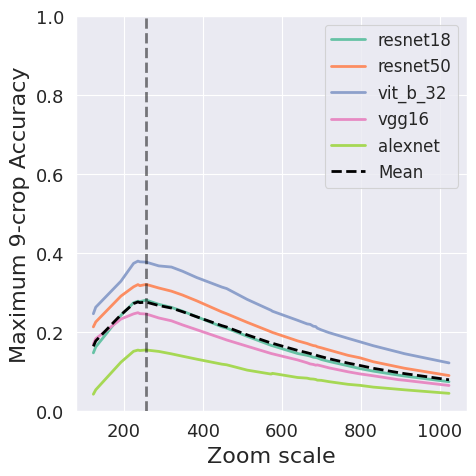

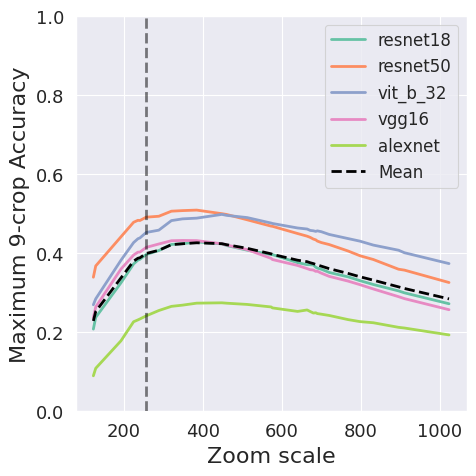

In [39]:
for dataset in dataset_names:
    plot_waterfall_all(dataset)

## Waterplot 1-crop accuracy

In [40]:
def plot_waterfall_1crop(df, dataset_name):
    fig, ax = plt.subplots(figsize=(15, 6), dpi=100, facecolor="w", edgecolor="k")
    sns.set_palette("Set2")
    sns.set_context("notebook", font_scale=3, rc={"lines.linewidth": 3})

    colors = sns.color_palette("Set2", 6)
    dark_colors = [sns.desaturate(c, 0.5) for c in colors]

    ctr = 0
    exclude_sizes = [10]

    for model, df in df.items():
        all_sizes = list(sorted(list(set([int(x.split(":")[-1]) for x in df.index]))))[:-8]
        acc_list = df.mean(1).loc[[f"LOC:1_1_Size:{s}" for s in all_sizes]]

        all_locs = []
        acc_list2 = []

        for s in all_sizes:
            for i in range(3):
                for j in range(3):
                    all_locs.append(f"LOC:{i}_{j}_Size:{s}")
            X = df.loc[all_locs]
            acc_list2.append(np.mean(X.max(0)))
            all_locs = []

        final_size, final_acc = zip(
            *[(s, a) for s, a in zip(all_sizes, acc_list) if s not in exclude_sizes]
        )
        plt.plot(
            final_size,
            final_acc,
            label=f"{pretty_model_names[model]}",
            color=colors[ctr],
            linewidth=3,
            marker="o",
            markersize=10,
            markerfacecolor="white",
            markeredgewidth=2,
            markeredgecolor=colors[ctr],
            zorder=1,
        )
        ctr += 1


    plt.xticks(np.arange(0, 800, 50), fontsize=18)
    plt.yticks(np.array(range(0, 101, 10)) / 100, fontsize=18)
    ax.set_yticklabels([f"{int(x)}" for x in range(0, 101, 10)])
    plt.vlines(256, 0, 1, linestyles="dashed")
    plt.legend(
        fontsize=15,
        loc="upper left",
        ncol=1,
        bbox_to_anchor=(0.0, 1.0),
        columnspacing=0.5,
        handletextpad=0.5,
        handlelength=1.5,
    )
    fig.suptitle(f"{pretty_dataset_names[dataset_name]} 1-crop accuracy", fontsize=20)
    plt.show()

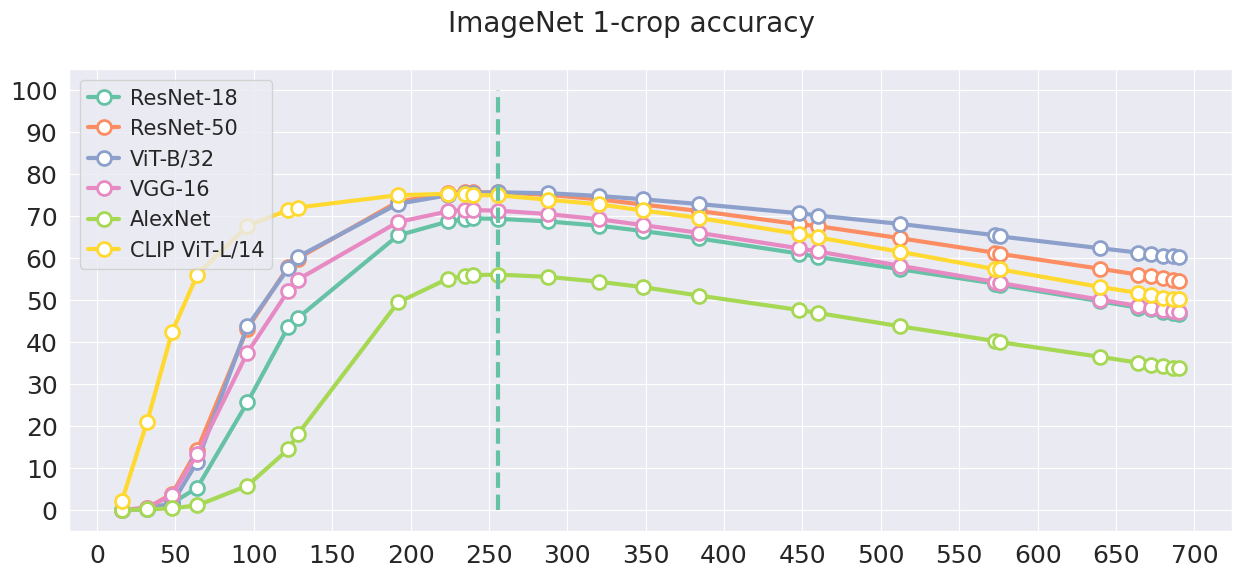

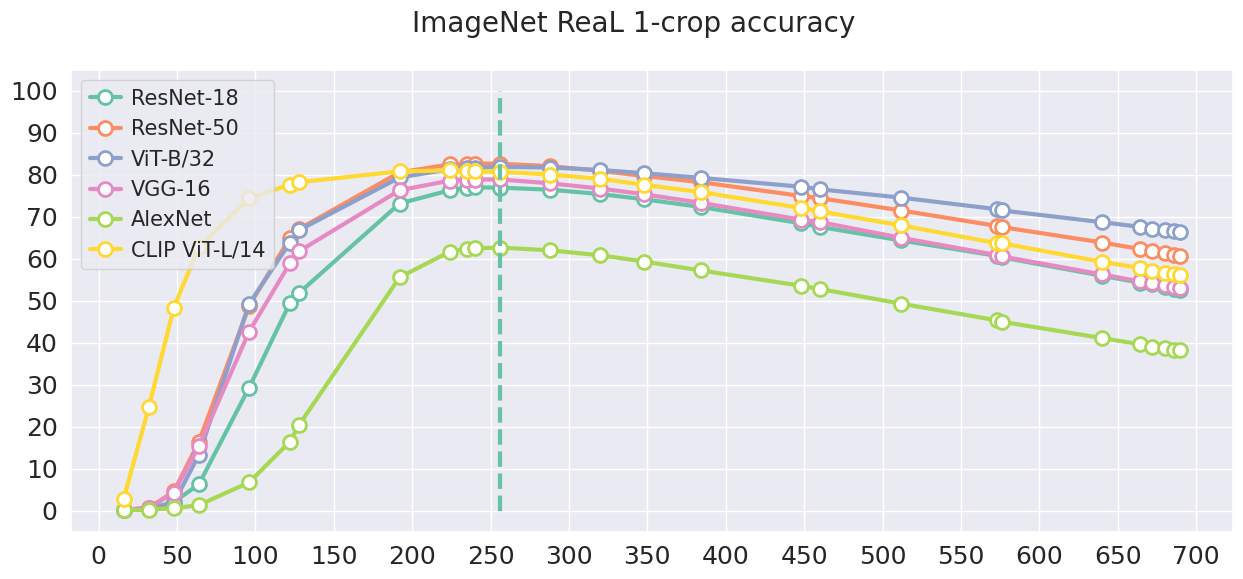

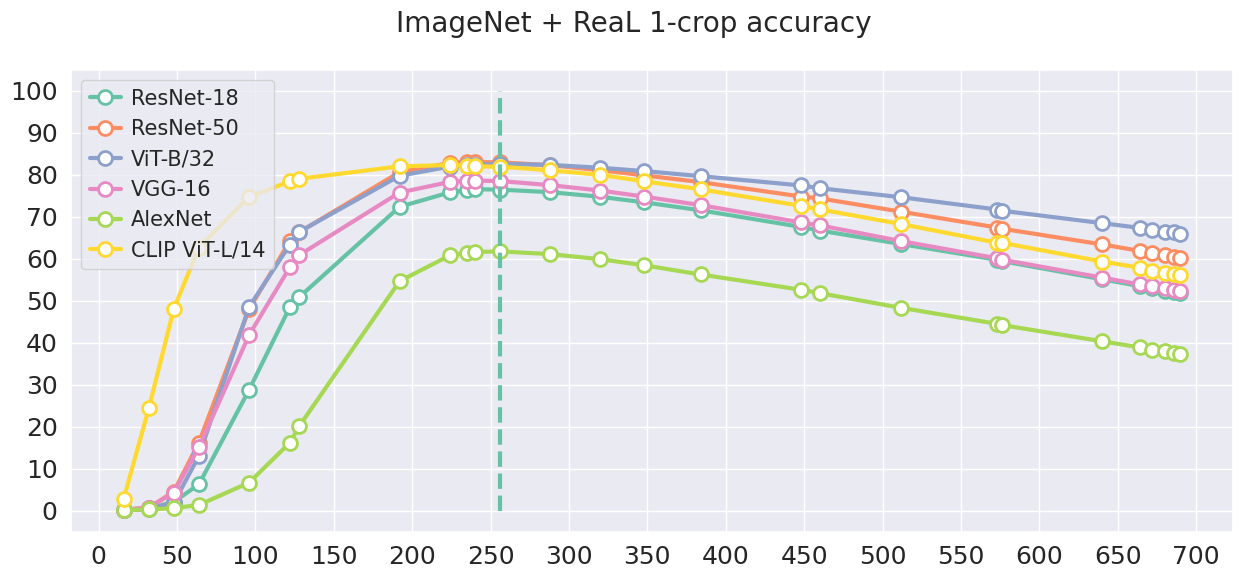

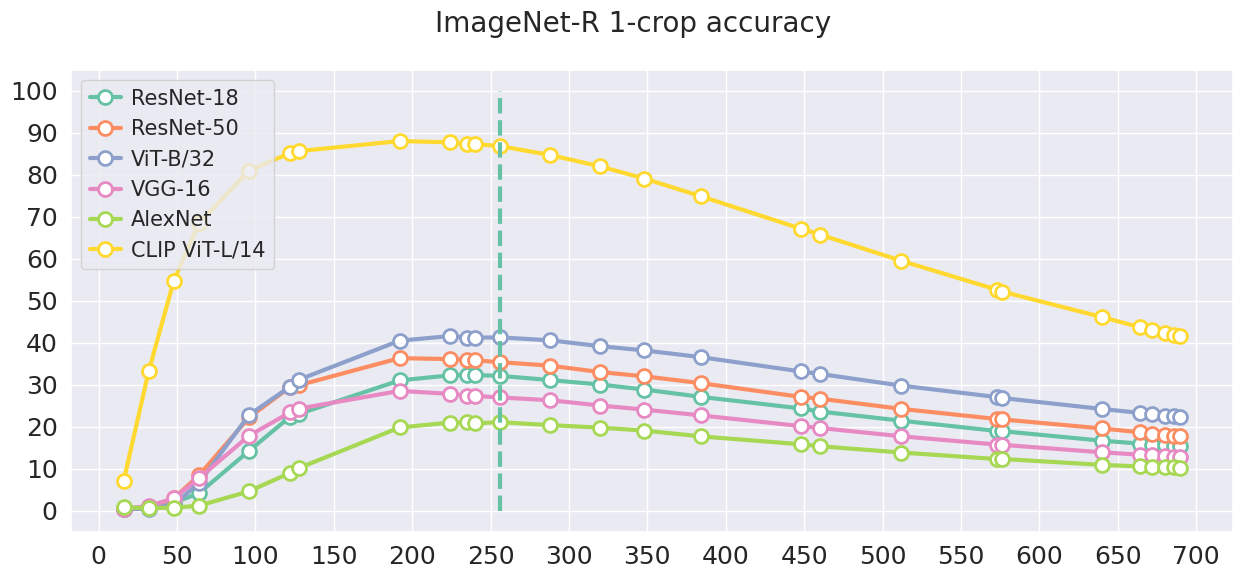

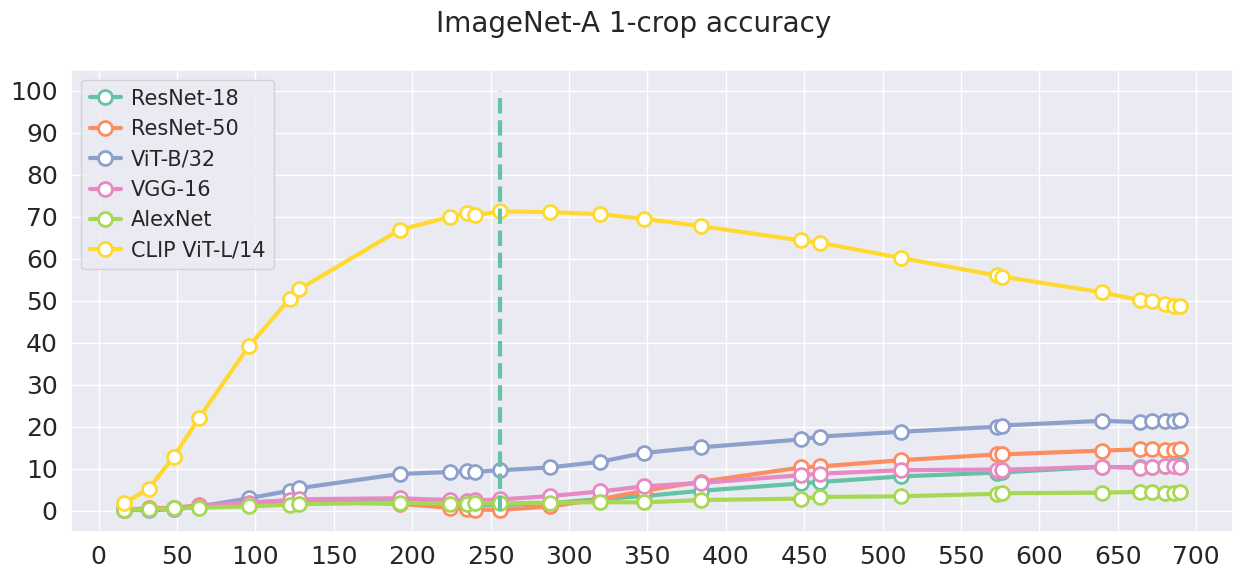

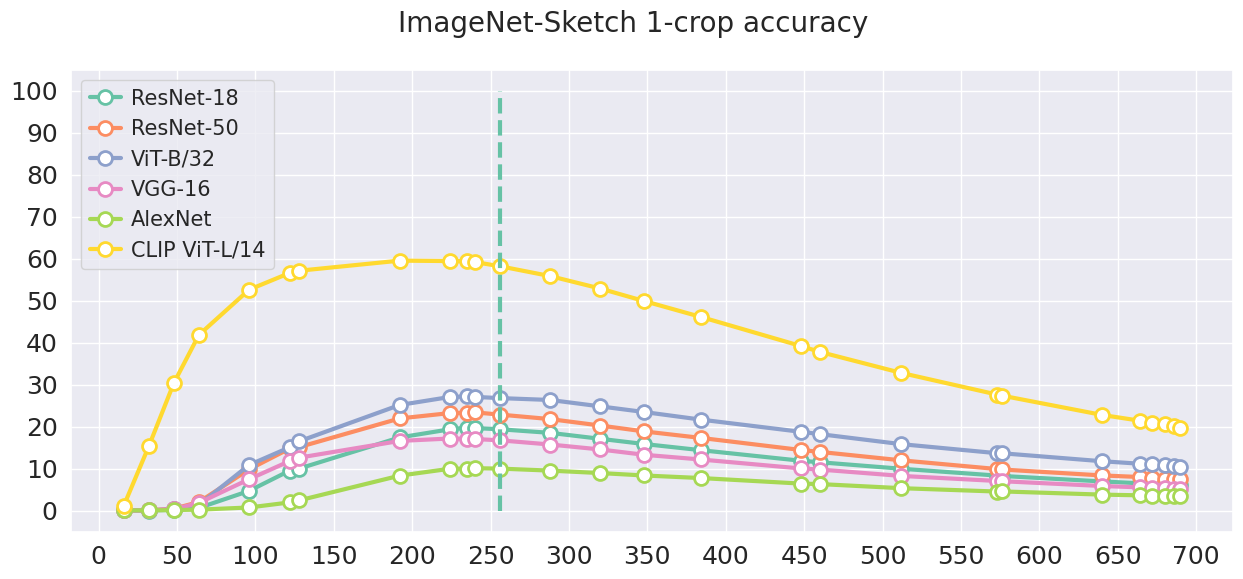

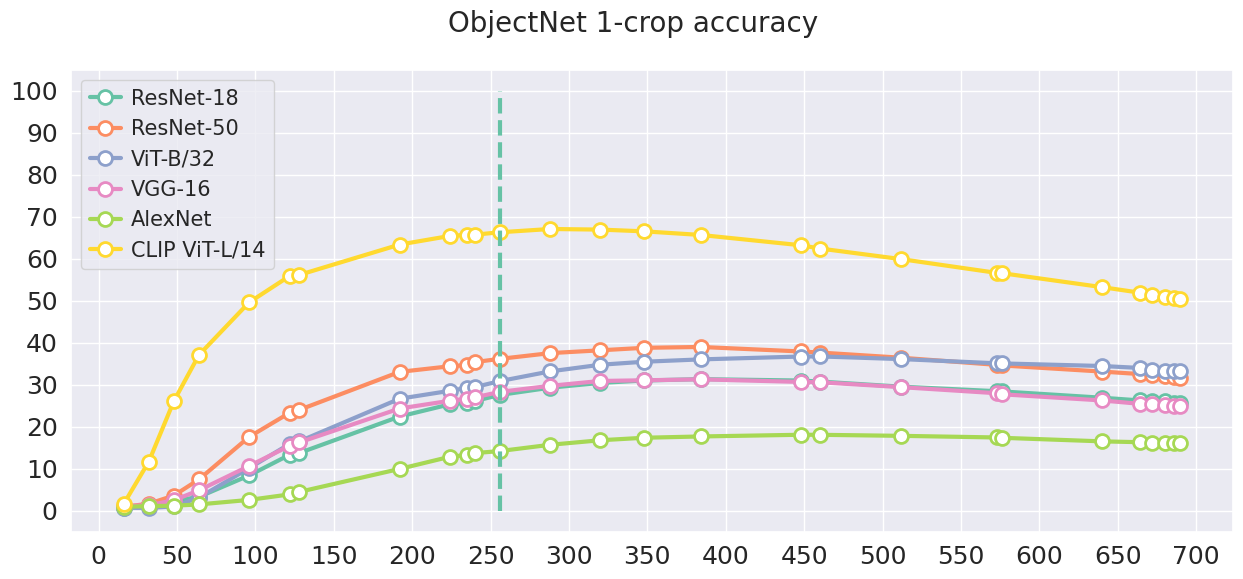

In [41]:
for dataset in dataset_names:
    plot_waterfall_1crop(correctness_dfs[dataset], dataset)